### IMPORT LIBRARIES

In [1]:
import os, io, random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from collections import Counter
import pathlib, shutil

### LOAD DATA

In [2]:
base_dir= "DATA"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

classes = ['melanoma', 'seborrheic_keratosis', 'nevus']

Realizamos una pequeña visualizacion de las imagenes pertenecientes a cada clase

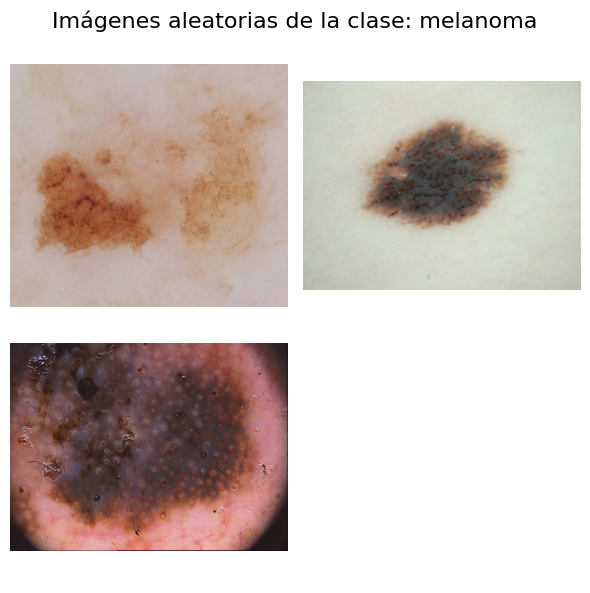

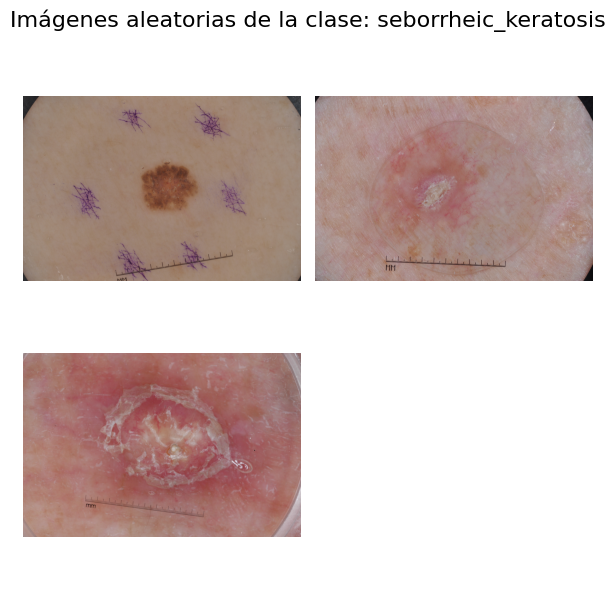

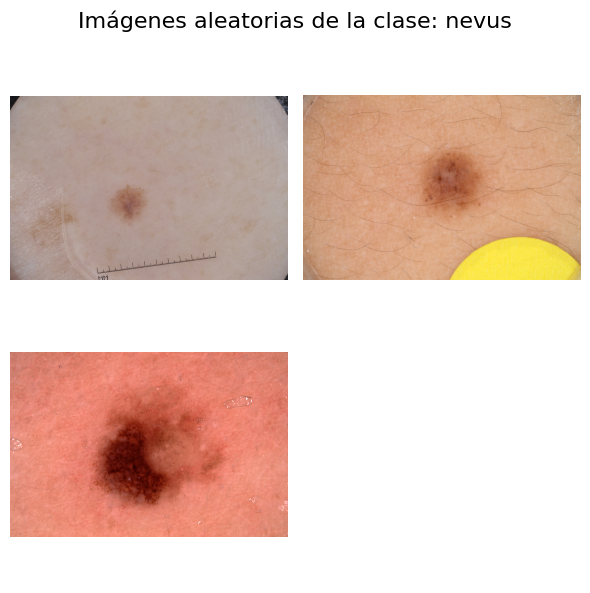

In [14]:

def mostrar_imagenes_aleatorias(directory, class_name, n: int = 3):
    """
    Muestra n imágenes aleatorias de la carpeta  dentro de 'directory'
    en un grid cuadrado lo más compacto posible.
    """
    class_path = os.path.join(directory, class_name)
    todas = os.listdir(class_path)
    muestrario = random.sample(todas, min(n, len(todas)))

    cols = math.ceil(math.sqrt(len(muestrario)))
    rows = math.ceil(len(muestrario) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6, 6))
    axes = axes.flatten()            
    for ax, img_name in zip(axes, muestrario):
        img_path = os.path.join(class_path, img_name)
        ax.imshow(load_img(img_path))
        ax.axis("off")

    for ax in axes[len(muestrario):]:
        ax.axis("off")

    fig.suptitle(f"Imágenes aleatorias de la clase: {class_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Ejecución para todas las clases
for class_name in classes:
    mostrar_imagenes_aleatorias(train_dir, class_name)


### HISTOGRAMA DE COLOR

Usando 2000 imágenes de entrenamiento para el histograma.


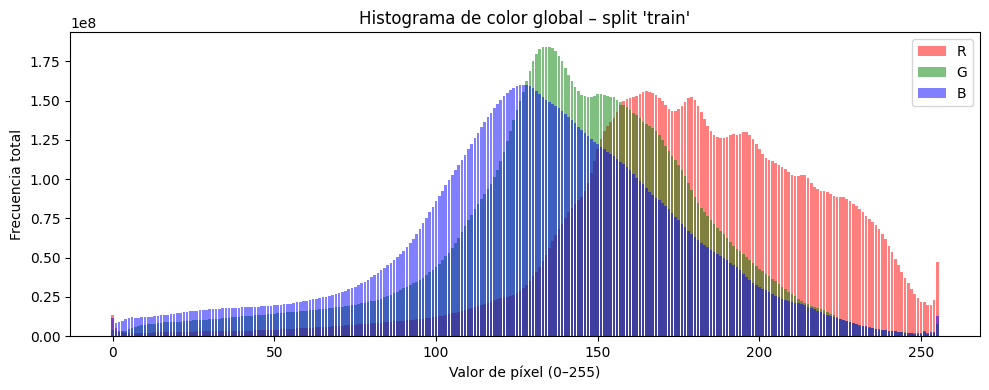

In [16]:

sample_size = None      # None todas las imágenes

#Recolectar rutas de TRAIN
train_paths = []
for cls in classes:
    folder = os.path.join(train_dir, cls)      
    if not os.path.isdir(folder):
        print(f"Aviso: {folder} no existe; se omite.")
        continue
    train_paths.extend(
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    )

if sample_size:
    train_paths = random.sample(train_paths, min(sample_size, len(train_paths)))

print(f"Usando {len(train_paths)} imágenes de entrenamiento para el histograma.")

# Cálculo del histograma global
hist_r = Counter({i:0 for i in range(256)})
hist_g = Counter({i:0 for i in range(256)})
hist_b = Counter({i:0 for i in range(256)})

for path in train_paths:
    img = Image.open(path).convert("RGB")
    arr = np.asarray(img, dtype=np.uint8)

    r, g, b = [np.bincount(arr[:, :, ch].ravel(), minlength=256) for ch in range(3)]
    hist_r.update(dict(enumerate(r)))
    hist_g.update(dict(enumerate(g)))
    hist_b.update(dict(enumerate(b)))

# Visualización del histograma
plt.figure(figsize=(10,4))
plt.bar(range(256), [hist_r[i] for i in range(256)], color='r', alpha=0.5, label='R')
plt.bar(range(256), [hist_g[i] for i in range(256)], color='g', alpha=0.5, label='G')
plt.bar(range(256), [hist_b[i] for i in range(256)], color='b', alpha=0.5, label='B')
plt.title("Histograma de color global – split 'train'")
plt.xlabel("Valor de píxel (0–255)")
plt.ylabel("Frecuencia total")
plt.legend()
plt.tight_layout()
plt.show()


El histograma muestra que la mayor parte de los píxeles del train se concentra en los tonos medios (100‑180), con un claro predominio del canal rojo, algo menos de verde y el azul como el más bajo; apenas hay píxeles extremadamente oscuros ni zonas saturadas, lo que indica imágenes bien expuestas y una dominante cromática rojiza típica de fotografía dermatológica.

### DISTRIBUCION DE PIXELES

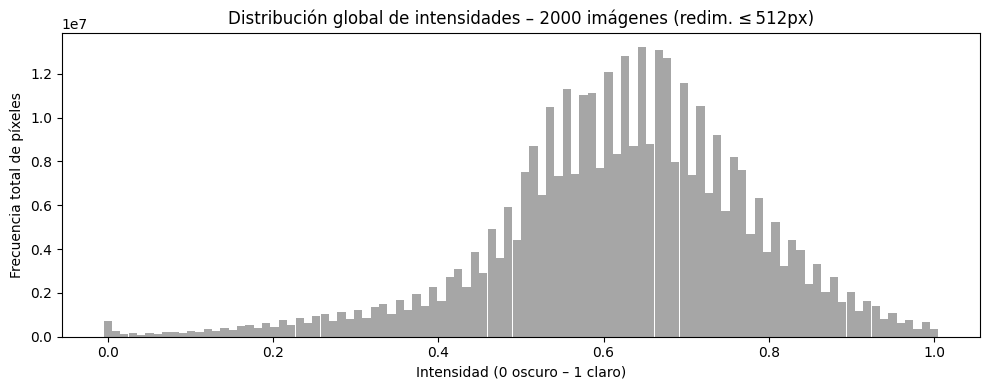

In [ ]:
def intensity_histogram(image_paths, bins=100, sample_size=None, max_side=512):
    if sample_size is not None and sample_size < len(image_paths):
        image_paths = random.sample(image_paths, sample_size)

    hist = np.zeros(bins, dtype=np.int64)

    for p in image_paths:
        with Image.open(p) as im:
            im = im.convert("L")                         # uint8, 1 canal
            if max_side is not None:
                im.thumbnail((max_side, max_side), Image.Resampling.LANCZOS)

            arr = np.asarray(im, dtype=np.uint8)
            h, _ = np.histogram(arr, bins=bins, range=(0, 256))
            hist += h

    return hist

# Cálculo del histograma de intensidad global
bins        = 100        # menos ruido que 256 
sample_size = None       # None = todas las imágenes
max_side    = 512        # reduce RAM < 0.3 MB por foto (None = sin redimensión)

hist = intensity_histogram(train_paths, bins=bins, sample_size=sample_size, max_side=max_side)

x = np.linspace(0, 1, bins)             # escalamos 0‑255, 0‑1 para el eje X
plt.figure(figsize=(10, 4))
plt.bar(x, hist, width=1/bins, color='gray', alpha=0.7)
title = f"Distribución de pixeles - {len(train_paths)} imágenes"
if max_side: title += f" (redim. ≤ {max_side}px)"
plt.title(title)
plt.xlabel("Intensidad (0 oscuro - 1 claro)")
plt.ylabel("Frecuencia total de píxeles")
plt.tight_layout(); plt.show()


El histograma muestra que la mayor parte de los píxeles se concentran entre aproximadamente 0,5 y 0,7 de intensidad (tonos medio‑claros), lo que indica imágenes bien iluminadas y con predominio de regiones claras. Hay muy poca presencia en los extremos: casi no aparecen píxeles superbrillantes (> 0,9) ni muy oscuros (< 0,1); los pequeños picos cercanos a 0 sugieren bordes negros o sombras puntuales. En general, el conjunto de datos presenta un contraste equilibrado y escasa saturación, por lo que bastará una normalización estándar (media‑desviación típica) antes de entrenar los modelos.

### TAMAÑO DE LAS IMAGENES

In [8]:
image_sizes = []

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    img = Image.open(img_path)
    image_sizes.append(img.size)

image_sizes = np.array(image_sizes)
mean_size = np.mean(image_sizes, axis = 0)
std_size = np.std(image_sizes, axis = 0)

print(f"Mean Image Size: {mean_size}")
print(f"Standard Deviation of Image Sizes: {std_size}")

Mean Image Size: [3317.33333333 2362.66666667]
Standard Deviation of Image Sizes: [713.7905077  374.62633235]


La alta desviación en las dimensiones de las imágenes indica que unas son mucho más grandes o pequeñas que otras; esto importa porque:

1. Las CNN solo aceptan tensores de tamaño fijo, así que cada lote tendrá que redimensionarse o rellenarse, introduciendo distorsiones o desperdiciando memoria. 
2. Los objetos de interés abarcarán proporciones distintas del encuadre según el tamaño original, dificultando que el modelo aprenda patrones coherentes.
3. Los gradientes y la velocidad de entrenamiento varían con el número de píxeles, lo que puede sesgar la optimización.

Para solucionar este problema redimensionamos todas las fotos al mismo tamaño para que el modelo siempre tenga las imágenes iguales. Luego, solo en el entrenamiento, las giramos un poco, las acercamos o las desplazamos para que practique con versiones variadas y aprenda a reconocer la clase aunque cambie ligeramente. En cambio, en validación y prueba dejamos las imágenes tal cual para comprobar de forma justa lo que el modelo ha aprendido.

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)


val_test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir, 
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False
)

Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


### BALANCEO DE LAS CLASES

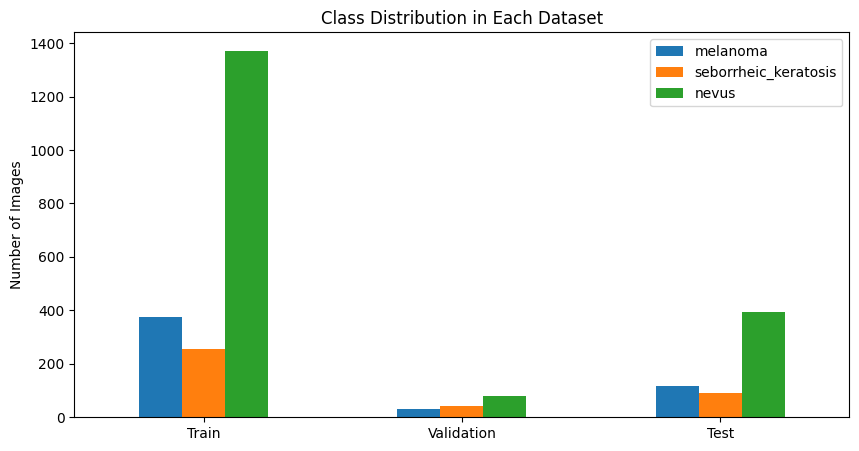

In [11]:
def count_images(directory):
    class_counts = {}
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images
    return class_counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

df = pd.DataFrame([train_counts, val_counts, test_counts], index = ['Train', 'Validation', 'Test'])
df.plot(kind = 'bar', figsize = (10,5))
plt.title('Class Distribution in Each Dataset')
plt.ylabel('Number of Images')
plt.xticks(rotation = 0)
plt.show()


In [12]:
df = pd.DataFrame([train_counts, val_counts, test_counts], index=['Train', 'Validation', 'Test'])
df_pct = df.div(df.sum(axis=1), axis=0) * 100                   
print("\nPorcentaje de cada clase:")
print(df_pct)



Porcentaje de cada clase:
            melanoma  seborrheic_keratosis  nevus
Train           18.7                  12.7   68.6
Validation      20.0                  28.0   52.0
Test            19.5                  15.0   65.5


Para arreglar el balanceo de clase Reducimos la clase nevus hasta quedar con el mismo número de imágenes que la segunda clase mayoritaria para poder eliminar el desbalance sin perder diversidad. Así evitamos que el modelo se incline hacia la clase dominante y, al mismo tiempo, mantenemos suficiente información de nevus para que aprenda sus patrones.

In [13]:
ROOT = pathlib.Path("DATA/train")  
KEEP_RATIO = 1.0                   

melanoma_dir   = ROOT / "melanoma"
nevus_dir      = ROOT / "nevus"
discarded_dir  = nevus_dir.parent / "_discarded"
discarded_dir.mkdir(exist_ok=True)

n_melanoma = len(list(melanoma_dir.glob("*")))
nevus_imgs = sorted(nevus_dir.glob("*"))                # orden fijo
max_nevus  = int(n_melanoma * KEEP_RATIO)
keep_nevus = nevus_imgs[:max_nevus]                     # mismas siempre
drop_nevus = nevus_imgs[max_nevus:]


for img in drop_nevus:
    shutil.move(str(img), discarded_dir / img.name)     # usa os.remove() para borrar

print(f"Conservadas {len(keep_nevus)} imágenes de nevus.")
print(f"Descartadas {len(drop_nevus)} → {discarded_dir}")

# Guardar la lista para control de versiones
with open("nevus_kept.txt", "w", encoding="utf-8") as f:
    f.writelines(f"{p.name}\n" for p in keep_nevus)
print("Lista de imágenes conservadas guardada en nevus_kept.txt")


Conservadas 374 imágenes de nevus.
Descartadas 998 → DATA\train\_discarded
Lista de imágenes conservadas guardada en nevus_kept.txt


In [14]:
train_counts2 = count_images(train_dir)
val_counts2 = count_images(val_dir)
test_counts2 = count_images(test_dir)

df = pd.DataFrame([train_counts2, val_counts2, test_counts2], index=['Train', 'Validation', 'Test'])
df_2 = df.div(df.sum(axis=1), axis=0) * 100                   
print("\nPorcentaje de cada clase:")
print(df_2)


Porcentaje de cada clase:
             melanoma  seborrheic_keratosis      nevus
Train       37.325349             25.349301  37.325349
Validation  20.000000             28.000000  52.000000
Test        19.500000             15.000000  65.500000
